# TCL visualization demo

In [1]:
from functools import lru_cache
from IPython.display import display as idisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms as T
import numpy as np
from pathlib import Path
from PIL import Image
import requests
from io import BytesIO
from omegaconf import OmegaConf
from einops import rearrange, repeat

from utils.config import load_config
from models import build_model
from mmseg import datasets as mmseg_datasets
from datasets.builder import build_text_transform

## Setting

In [2]:
device = "cuda"
ckpt_path = "./checkpoints/tcl.pth"
size = 224  # resize shorter side of image to 224

In [3]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform(n_px):
    return T.Compose([
        T.Resize(n_px, interpolation=T.InterpolationMode.BICUBIC),
        _convert_image_to_rgb,
        T.ToTensor(),
        T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])

preprocess = _transform(size)

In [4]:
def unnorm(x):
    """Un-normalize pytorch tensor by imagenet mean/std.
    output range is [0.0, 1.0].
    """
    mean = torch.as_tensor(IMAGENET_DEFAULT_MEAN, device=x.device)[None, ..., None, None]
    std = torch.as_tensor(IMAGENET_DEFAULT_STD, device=x.device)[None, ..., None, None]
    
    return x.mul(std).add(mean)

In [5]:
tokenizer = build_text_transform()

In [6]:
from models.tcl.pamr import PAMR

pamr = PAMR(10, [1, 2, 4, 8, 12, 24]).eval().to(device)

## Load model

In [7]:
print(f"Load {ckpt_path} ...")
ckpt = torch.load(ckpt_path)
cfg = OmegaConf.load("./configs/tcl.yml")
model = build_model(cfg.model)

# The (minimal) checkpoint only contains learned parameters; Frozen CLIP params are not contained.
model.load_state_dict(ckpt['model'], strict=False);  # load quietly
model.to(device).eval()

Load ./checkpoints/tcl.pth ...


## Visualization functions

In [8]:
def to_grid(tensor, to, **kwargs):
    """ Integrated functions of make_grid and save_image
    Possible conversions:
        torch: torch tensor [0, 1]
        numpy: numpy ndarr [0, 255]
        pil: PIL image
    """
    to = to.lower()

    grid = tv.utils.make_grid(tensor, **kwargs, normalize=True)
    if to == 'torch':
        return grid

    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    if to == 'numpy':
        return ndarr

    im = Image.fromarray(ndarr)
    if to == 'pil':
        return im

    raise ValueError("Not supported target format `{}`".format(to))

In [9]:
PALETTE = mmseg_datasets.PascalVOCDataset.PALETTE

In [10]:
from demo.image_text import ImageText

def make_textbox(text, size, fontsize=20, color=(0,0,0), bg=(255,255,255), pad=10, **kwargs):
    """https://gist.github.com/pojda/8bf989a0556845aaf4662cd34f21d269
    
    Args:
        text
        size: [W, H]
        pad: side (left & right) padding

    Return:
        PIL.Image
    """
    font = 'demo/Arialn.ttf'
    img = ImageText(size, mode="RGB", background=bg)
    box_width = size[0] - pad*2

    img.write_text_box((pad, 0), text, box_width=box_width, font_filename=font,
                       font_size=fontsize, color=color, place='center', position='middle', **kwargs)
    
    return img.image

In [11]:
def get_palette_colormap(texts, palette, boxsize=(360, 48), fontsize=20, nrow=None):
    if nrow is None:
        nrow = len(texts)
    
    boxes = []
    
    for i, text in enumerate(texts):
        color = palette[i]
        box = make_textbox(
            text, 
            boxsize, 
            fontsize=fontsize,
            bg=tuple(color), 
            pad=0,
            color=(255, 255, 255),
            stroke_width=2,
            stroke_fill=0,
        )
        box = tv.transforms.functional.to_tensor(box)
        boxes.append(box)
    
    textboxes = torch.stack(boxes)
    
    return to_grid(textboxes, "pil", nrow=nrow, pad_value=1.0, padding=1)

In [12]:
@lru_cache()
def get_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

In [13]:
def visualize(
    model, image, texts, palette=None, opacity=0.5, apply_pamr=True,
    pos_interpolate=True, kp_w=0.3, with_bg=True, out_scale=1.0
):
    """visualize single segmap"""
    if palette is None:
        # Use VOC palette
        palette = PALETTE
        palette[0] = [255, 255, 255]
    
    # BG thresholding
    bg_thresh = 0.4 if apply_pamr else 0.5

    image = preprocess(image).unsqueeze(0).to(device)
    box_shape = list(image.shape[2:])
    text = tokenizer(texts).to(device)

    mask, simmap = model.generate_masks(
        image,
        text, 
        text_is_token=True,
        pos_interpolate=pos_interpolate,
        kp_w=kp_w
    )
    
    if apply_pamr:
        mask = pamr(image, mask)

    I, T, H, W = mask.shape
    if with_bg:
        bg = torch.full(
            [I, 1, H, W],
            bg_thresh,
            dtype=torch.float,
            device=mask.device
        )
        bg_mask = torch.cat([bg, mask], dim=1)
        cur_palette = palette
    else:
        bg_mask = mask
        cur_palette = palette[1:]

    # generate segmap from masks
    assert I == 1
    seg = bg_mask.max(dim=1).indices.squeeze(0).cpu().numpy()  # [H, W]; integer segmap
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(cur_palette):
        color_seg[seg == label, :] = color

    color_seg = torch.as_tensor(color_seg, dtype=torch.float) / 255.  # [H, W, 3]
    color_seg = rearrange(color_seg, "H W C -> () C H W").to(device)  # [1, 3, H, W]

    fg = torch.as_tensor(repeat(seg != 0, "H W -> () (3) H W")).to(device)
    if not with_bg:
        fg = torch.ones_like(fg)  # all fg.
    segimg = unnorm(image)
    segimg[fg] = segimg[fg] * (1 - opacity) + color_seg[fg] * opacity

    res = [unnorm(image), segimg]
    nrow = len(res)
    ts = torch.cat(res)

    output = to_grid(ts, "pil", nrow=nrow, value_range=(0.0, 1.0), pad_value=255)
    
    if out_scale != 1.0:
        H, W = output.size
        out_scale = 0.7
        output = output.resize((int(H*out_scale), int(W*out_scale)))

    cmap = get_palette_colormap(texts, palette[1:], nrow=3)
    
    return output, cmap


def visualize_url(model, url, texts):
    img = get_image(url)
    return visualize(model, img, texts)

## Examples

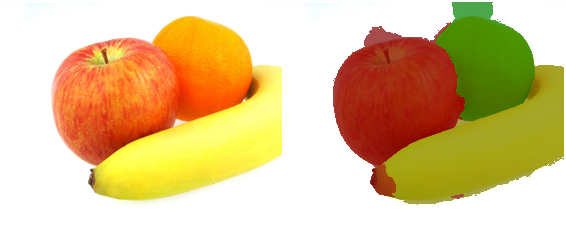

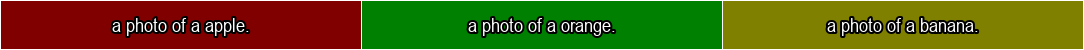

In [14]:
texts = [
    "a photo of a apple.",
    "a photo of a orange.",
    "a photo of a banana.",
]

url = "https://images.thestar.com/hfPr1NOqUHiwhx9_KCAO45CuJPM=/1280x1024/smart/filters:cb(1566585594243)/https://www.thestar.com/content/dam/thestar/life/food_wine/2013/11/04/apples_oranges_or_bananas_which_fruit_is_nutritionally_the_best/apple_orange_banana.jpg"
img = get_image(url)

seg, cmap = visualize(
    model, 
    img, 
    texts,
    opacity=0.7,
    kp_w=0.3,
)
idisplay(seg, cmap)

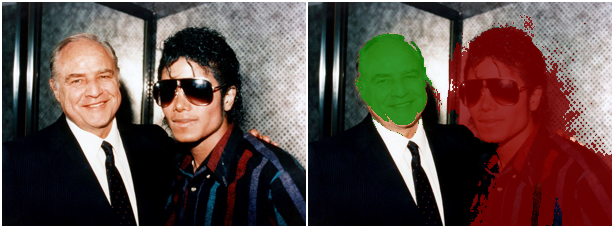

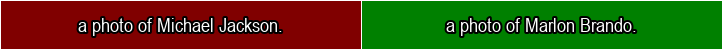

In [15]:
texts = [
    "a photo of Michael Jackson.",
    "a photo of Marlon Brando.",
]

url = "https://faroutmagazine.co.uk/static/uploads/2022/06/Exploring-Marlon-Brandos-relationship-with-Michael-Jackson.jpg"
img = get_image(url)

seg, cmap = visualize(
    model, 
    img, 
    texts,
    palette=None,
    apply_pamr=True,
    opacity=0.8,
    kp_w=0.3,
)
idisplay(seg, cmap)

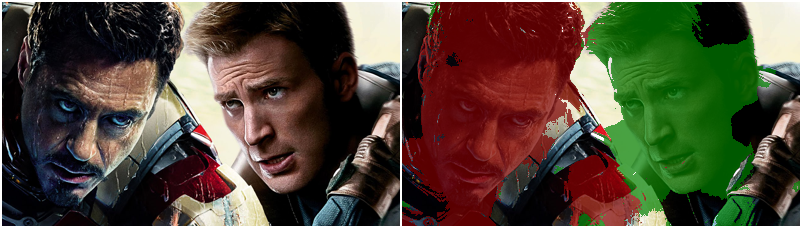

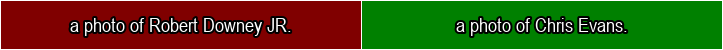

In [16]:
texts = [
    "a photo of Robert Downey JR.",
    "a photo of Chris Evans.",
]

url = "https://i.ytimg.com/vi/JbL9uf5MLxM/maxresdefault.jpg"
img = get_image(url)

seg, cmap = visualize(
    model, 
    img, 
    texts,
    palette=None,
    apply_pamr=True,
    opacity=0.7,
    kp_w=0.3,
)
idisplay(seg, cmap)

### Example with background description

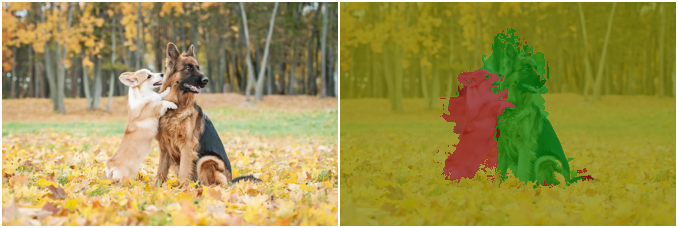

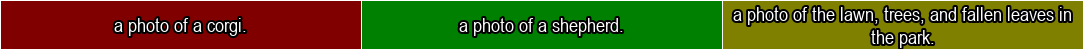

In [17]:
texts = [
    "a photo of a corgi.",
    "a photo of a shepherd.",
    "a photo of the lawn, trees, and fallen leaves in the park.",  # background description
]

url = "https://www.perfectdogbreeds.com/wp-content/uploads/2019/09/Corgi-German-Shepherd-Mix-Care-Guide-The-Perfect-Family-Companion-Cover.jpg"
img = get_image(url)

seg, cmap = visualize(
    model,
    img, 
    texts,
    opacity=0.7,
    with_bg=False  # turn off background thresholding
)
idisplay(seg, cmap)